<a href="https://colab.research.google.com/github/lulujal/clustering/blob/main/clustered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Baca data
data = pd.read_csv('LayerMarkerCSV.csv')

# Tampilkan beberapa baris pertama
print(data.head())

                       Name description  extrude  Latitude   Longitude
0               cctv e11(1)         NaN        0 -7.050569  110.401253
1              cctv e11 (2)         NaN        0 -7.050572  110.401249
2              cctv e11 (3)         NaN        0 -7.050578  110.401247
3  cctv pos satpam doraemon         NaN        0 -7.053340  110.400767
4             pos satpam ft         NaN        0 -7.051707  110.400954


In [ ]:
import numpy as np

coords = data[['Latitude', 'Longitude']].values
coords = np.radians(coords)


In [ ]:
from sklearn.cluster import DBSCAN

# Menggunakan epsilon dalam satuan radian
epsilon_meter = 20 # Misalnya 1 meter
epsilon_radian = epsilon_meter / 6371000

# Menjalankan DBSCAN
db = DBSCAN(eps=epsilon_radian, min_samples=2, metric='haversine').fit(coords)

# Tambahkan hasil clustering ke GeoDataFrame
data['cluster'] = db.labels_

# Tampilkan jumlah kluster yang ditemukan
num_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(f"Jumlah kluster yang ditemukan: {num_clusters}")


Jumlah kluster yang ditemukan: 22


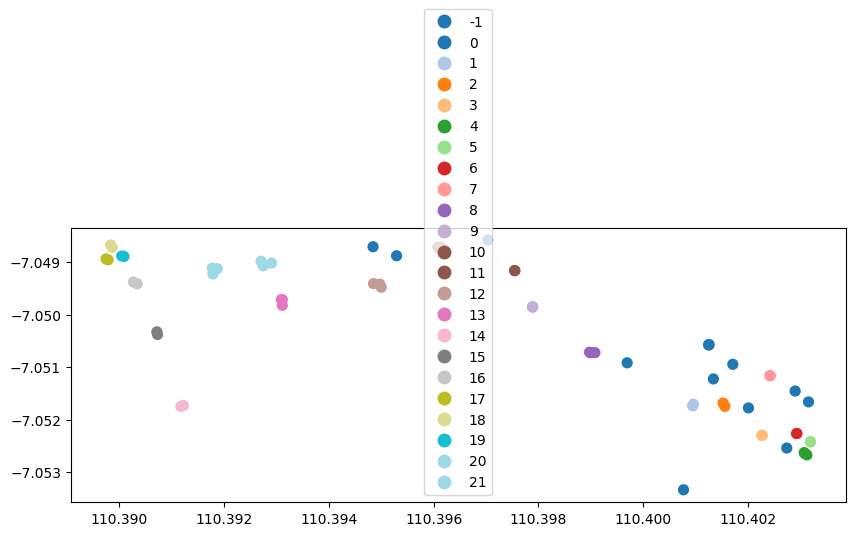

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Membuat GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']))
# Visualisasi hasil clustering
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='cluster', categorical=True, legend=True, markersize=50, cmap='tab20')
plt.show()

In [ ]:
from geopy.distance import geodesic

def compute_distance(lat1, lon1, lat2, lon2):
    """
    Menghitung jarak geodesik antara dua titik dalam meter.
    """
    return geodesic((lat1, lon1), (lat2, lon2)).meters


In [ ]:
def adjust_points(data, min_safe_distance):
    """
    Menggeser titik yang terlalu berdekatan agar jaraknya minimal 'min_safe_distance' meter.
    """
    points = data[['Latitude', 'Longitude']].values
    num_points = len(points)

    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = compute_distance(points[i][0], points[i][1], points[j][0], points[j][1])
            if dist < min_safe_distance:
                # Menggeser kedua titik agar jarak aman terpenuhi
                delta_lat = points[j][0] - points[i][0]
                delta_lon = points[j][1] - points[i][1]
                scale = min_safe_distance / dist

                # Geser titik
                points[j][0] = points[i][0] + delta_lat * scale
                points[j][1] = points[i][1] + delta_lon * scale

    return points


In [ ]:
# Menentukan jarak aman minimal dalam meter, misalnya 22 meter
min_safe_distance = 22

# Terapkan penyesuaian jarak
adjusted_coords = adjust_points(data, min_safe_distance)

# Memperbarui koordinat dalam DataFrame
data['Latitude'] = adjusted_coords[:, 0]
data['Longitude'] = adjusted_coords[:, 1]


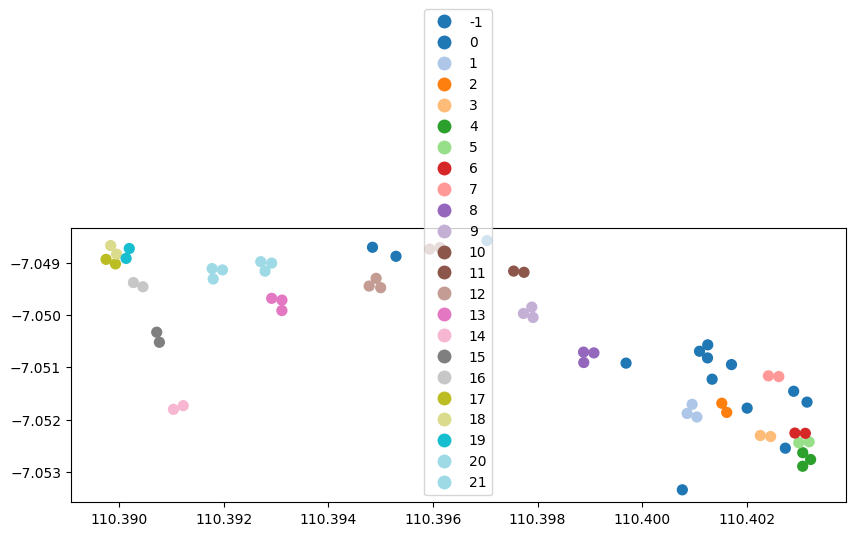

Hasil clustering telah disimpan ke: LayerMarkerCSV_with_clusters.csv


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Membuat GeoDataFrame dengan titik yang telah disesuaikan
gdf_adjusted = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Longitude'], data['Latitude']))

# Visualisasi hasil clustering setelah penyesuaian
fig, ax = plt.subplots(figsize=(10, 10))
gdf_adjusted.plot(ax=ax, column='cluster', categorical=True, legend=True, markersize=50, cmap='tab20')
plt.show()

# Simpan hasil ke file CSV
output_path = 'LayerMarkerCSV_with_clusters.csv'
data.to_csv(output_path, index=False)
print(f"Hasil clustering telah disimpan ke: {output_path}")


In [ ]:
import pandas as pd
import geopandas as gpd

# Baca data dari CSV
data = pd.read_csv('LayerMarkerCSV_with_clusters.csv')

# Konversi ke GeoDataFrame
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['Longitude'], data['Latitude'])
)

# Tentukan CRS (Coordinate Reference System), misalnya WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Simpan sebagai Shapefile
gdf.to_file("LayerMarker_with_clusters.shp")


<ipython-input-16-689d611cd5b5>:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("LayerMarker_with_clusters.shp")


In [ ]:
%pip install simplekml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=e762504a0e0b85872a57f9322022a2ea9848577d3b2b38dac52a1feb679bc9d3
  Stored in directory: /root/.cache/pip/wheels/16/7c/e6/621a95f24bd1ff987368f1c37881ffe013433ff6b413d87fcb
Successfully built simplekml


In [ ]:
import pandas as pd
import simplekml

# Baca data dari CSV
data = pd.read_csv('LayerMarkerCSV_with_clusters.csv')

# Buat objek KML
kml = simplekml.Kml()

# Iterasi melalui setiap baris data
for idx, row in data.iterrows():
    # Tambahkan titik ke KML
    kml.newpoint(
        name=f"Cluster {row['cluster']}",
        coords=[(row['Longitude'], row['Latitude'])]
    )

# Simpan KML ke file
kml.save("LayerMarker_with_clusters.kml")
